In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error
import sklearn.preprocessing
from tqdm import tqdm

from src.mlhgp import MLHGP
from src.imlhgp import IMLHGP
from src.nnpehgp import NNPEHGP
from src.kshgp import KSHGP
from src.ksmlhgp import KSMLHGP
from src.ksimlhgp import KSIMLHGP
from src.rnmlhgp import RNHGP as RNHGP2
from src.rnimlhgp import RNHGP as RNHGP3
from src import evaluator

## SUPPRESS ALL WARNINGS
import warnings
warnings.filterwarnings("ignore")

import scienceplots

plt.style.use('science')

In [2]:
params = {'xtick.labelsize':12,
          'ytick.labelsize':12,
          'axes.labelsize': 16,
          'axes.titlesize': 18}
plt.rcParams.update(params)

# Problem Definition

In [3]:
def fun_2d(x1, x2):
    y = x1**3.5 + x2**2 - 3*x1*x2
    return y.reshape(-1,1)

def noise_fun(x2):
    noise = 0.1 * (x2)
    return noise.reshape(-1,1)

## Try and compare one pass

### Training data

In [4]:
np.random.seed(42)
X_train = np.random.uniform(low=0, high=1, size=(50,2))
y_train_mean = fun_2d(X_train[:,0], X_train[:,1])
y_train_std = noise_fun(X_train[:,1])

y_train = np.random.normal(y_train_mean, y_train_std)

### Testing Data

In [5]:
x1 = np.linspace(0,1,100)
x2 = np.linspace(0,1,100)
X1, X2 = np.meshgrid(x1, x2)
X1 = X1.reshape(100**2,1)
X2 = X2.reshape(100**2,1)
X_test = np.concatenate((X1,X2), axis=1)

# Compute loc and scale as functions of input X
y_test_mean = fun_2d(X_test[:,0], X_test[:,1])
y_test_std = noise_fun(X_test[:,1])

# Sample outputs Y from Gaussian Likelihood
np.random.seed(42)
y_test = np.random.normal(y_test_mean, y_test_std)

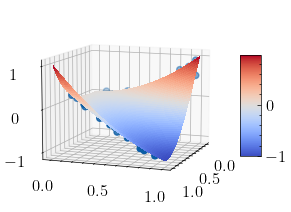

In [6]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(X1.reshape(100,100), X2.reshape(100,100), y_test_mean.reshape(100,100), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.scatter3D(X_train[:,0], X_train[:,1], y_train)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(elev=10, azim=20)

plt.show()

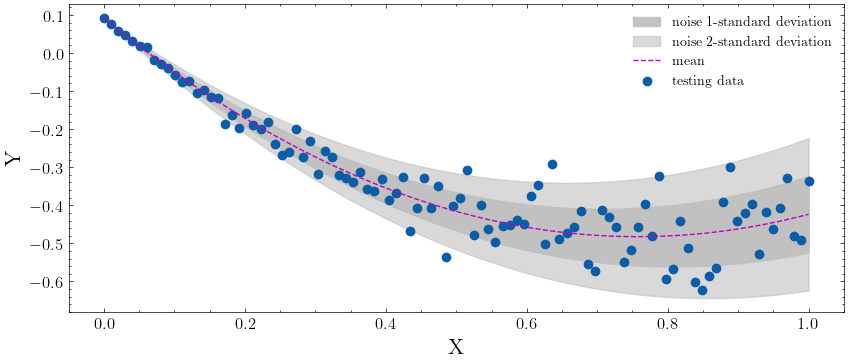

In [7]:
plt.figure(figsize=(10, 4))
for k in (1, 2):
    lb = (y_test_mean.reshape(100,100)[:,50] - k * y_test_std.reshape(100,100)[:,50]).squeeze()
    ub = (y_test_mean.reshape(100,100)[:,50] + k * y_test_std.reshape(100,100)[:,50]).squeeze()
    plt.fill_between(X2.reshape(100,100)[:,50], lb, ub, color="silver", alpha=1 - 0.05 * k ** 3, label=f"noise {k}-standard deviation")
plt.plot(X2.reshape(100,100)[:,50], y_test_mean.reshape(100,100)[:,50], '--m', label="mean")
plt.scatter(X2.reshape(100,100)[:,50], y_test.reshape(100,100)[:,50], label="testing data")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("img/case3_2d/original_function.pdf", dpi=300, format="pdf")
plt.show()

## Define Models


In [8]:
# define the model
def hgp_constructor(X_train_norm, y_train, kernel, kernel_noise):
    hgps = [MLHGP,IMLHGP,NNPEHGP,KSMLHGP,KSIMLHGP]
    trained_hgps = []

    for hgp in hgps:
        # Initialize models
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
        gp_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)
        model_hgp = hgp(model=gp, model_noise=gp_noise)

        # fit the model
        model_hgp.fit(X_train_norm, y_train.flatten())
        trained_hgps.append(model_hgp)

    return trained_hgps

In [9]:
kernel = ConstantKernel(1.0) * RBF(length_scale=(1e1, 1e1), length_scale_bounds=((1e-3, 1),(1e-3, 1))) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-4, 5e-1)
    )
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=(1e1, 1e1), length_scale_bounds=((1e-3, 1),(1e-3, 1))) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-4, 8e-2)
)
hgp = hgp_constructor(X_train, y_train, kernel, kernel_noise)

In [10]:
# make a prediction 
model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
res_dict = {}
for idx,hgp_model in tqdm(enumerate(hgp)):
    subres_dict = {}
    Y_pred, Std_pred = hgp_model.predict(X_test, return_std="multi")
    subres_dict["y_pred"] = Y_pred
    subres_dict["std_pred"] = Std_pred
    res_dict[model_name[idx]] = subres_dict

5it [00:00, 15.54it/s]


## Quantitative Evaluation

In [11]:
def score_eval(X_test, y_test_mean, y_test_std, y_pred, std_al, std_ep):

    # Compute average Wasserstein distance (Earth moving distance)
    d_wass_list = []
    for i,x in enumerate(X_test):
        # actual distribution
        act_dist = [y_test_mean[i,:], y_test_std[i,:]]
        pred_dist = [y_pred[i], std_al[i]]

        d_wass, dists, m2 = evaluator.wasserstein2(act_dist, pred_dist)
        d_wass_list.append(d_wass)
    
    avg_wass = np.mean(d_wass_list)

    # Compute SMSE of noise
    smse = evaluator.noise_smse(std_al, y_test_std)

    # Compute NLPD
    std_tot = np.sqrt(std_al**2 + std_ep**2)
    nlpd = evaluator.nlpd_loss(y_test_mean, y_pred, std_tot**2)

    return avg_wass, smse, nlpd

In [12]:
for name in model_name:
    res = res_dict[name]
    y_pred = res["y_pred"]
    std_al, std_ep = res["std_pred"]
    avg_wass, smse, nlpd = score_eval(X_test, y_test_mean, y_test_std, y_pred, std_al, std_ep)
    print(name)
    print(f"Average Wasserstein: {avg_wass}, Noise SMSE: {smse}, NLPD: {nlpd}")

MLHGP
Average Wasserstein: 0.001555139786677072, Noise SMSE: 0.6057974737899139, NLPD: 0.68041680263471
IMLHGP
Average Wasserstein: 0.0016458579010965408, Noise SMSE: 0.5671085194246985, NLPD: 0.6930264379492891
NNPEHGP
Average Wasserstein: 0.0020291637612142037, Noise SMSE: 0.7154496097896991, NLPD: 0.6859770180500113
KSMLHGP
Average Wasserstein: 0.0025183695485887212, Noise SMSE: 0.9662986121745745, NLPD: 0.6783267799506512
KSIMLHGP
Average Wasserstein: 0.002321046691078024, Noise SMSE: 0.8939257438768619, NLPD: 0.6822294956061511


In [13]:
hgp[4].model.kernel_

1.4**2 * RBF(length_scale=[0.973, 1])

## Varying random seeds

In [14]:
def train_data_maker(seednum, samp_size=25):
    np.random.seed(seednum)
    X_train = np.random.uniform(low=0, high=1, size=(samp_size,2))
    y_train_mean = fun_2d(X_train[:,0], X_train[:,1])
    y_train_std = noise_fun(X_train[:,1])

    y_train = np.random.normal(y_train_mean, y_train_std)

    return X_train, y_train

In [15]:
def main(datasize, repeat=100):

    model_name = ["MLHGP", "IMLHGP", "NNPEHGP", "KSMLHGP", "KSIMLHGP"]
    metrics_name = ["wasserstein", "smse", "nlpd", "model"]

    ## Initialize metrics dictionary
    model_scores = dict()
    for met in metrics_name:
        model_scores[met] = dict()
        for name in model_name:
            model_scores[met][name] = []
    
    model_scores["train_data"] = []

    for i in tqdm(range(repeat)):
        X_train, y_train = train_data_maker(seednum=i, samp_size=datasize)
        train = {"x": X_train, "y": y_train}
        model_scores["train_data"].append(train)
        
        # Test data
        x1 = np.linspace(0,1,100)
        x2 = np.linspace(0,1,100)
        X1, X2 = np.meshgrid(x1, x2)
        X1 = X1.reshape(100**2,1)
        X2 = X2.reshape(100**2,1)
        X_test = np.concatenate((X1,X2), axis=1)

        # Compute loc and scale as functions of input X
        y_test_mean = fun_2d(X_test[:,0], X_test[:,1])
        y_test_std = noise_fun(X_test[:,1])

        # Sample outputs Y from Gaussian Likelihood
        np.random.seed(42)
        y_test = np.random.normal(y_test_mean, y_test_std)
        
        # Normalize X
        # No need to normalize, scale already 0-1

        # Train models
        kernel = ConstantKernel(1.0) * RBF(length_scale=(1e1, 1e1), length_scale_bounds=((1e-3, 1),(1e-3, 1))) + WhiteKernel(
        noise_level=1, noise_level_bounds=(1e-4, 5e-1)
        )
        kernel_noise = ConstantKernel(1.0) * RBF(length_scale=(1e1, 1e1), length_scale_bounds=((1e-3, 1),(1e-3, 1))) + WhiteKernel(
            noise_level=1, noise_level_bounds=(1e-4, 8e-2)
        )
        hgp = hgp_constructor(X_train, y_train, kernel, kernel_noise)

        # make a prediction
        res_dict = {}
        for idx,hgp_model in enumerate(hgp):
            subres_dict = {}
            Y_pred, Std_pred = hgp_model.predict(X_test, return_std="multi")
            subres_dict["y_pred"] = Y_pred
            subres_dict["std_pred"] = Std_pred
            res_dict[model_name[idx]] = subres_dict
            model_scores["model"][model_name[idx]].append(hgp_model)
        
        # Evaluate
        for name in model_name:
            res = res_dict[name]
            y_pred = res["y_pred"]
            std_al, std_ep = res["std_pred"]
            avg_wass, smse, nlpd = score_eval(X_test, y_test_mean, y_test_std, y_pred, std_al, std_ep)
            model_scores["wasserstein"][name].append(avg_wass)
            model_scores["smse"][name].append(smse)
            model_scores["nlpd"][name].append(nlpd)
        
    return model_scores

In [16]:
model_scores = main(datasize=50, repeat=25)

100%|██████████| 25/25 [26:25<00:00, 63.43s/it]


In [24]:
params = {'xtick.labelsize':14,
          'ytick.labelsize':14,
          'axes.labelsize': 20,
          'axes.titlesize': 22}
plt.rcParams.update(params)

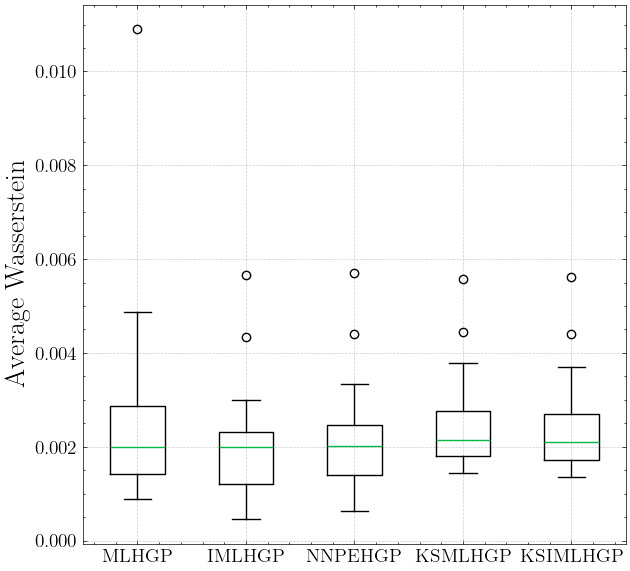

In [25]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["wasserstein"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylabel("Average Wasserstein")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/case3_2d/average_wasserstein.pdf", dpi=300, format="pdf")
plt.show()

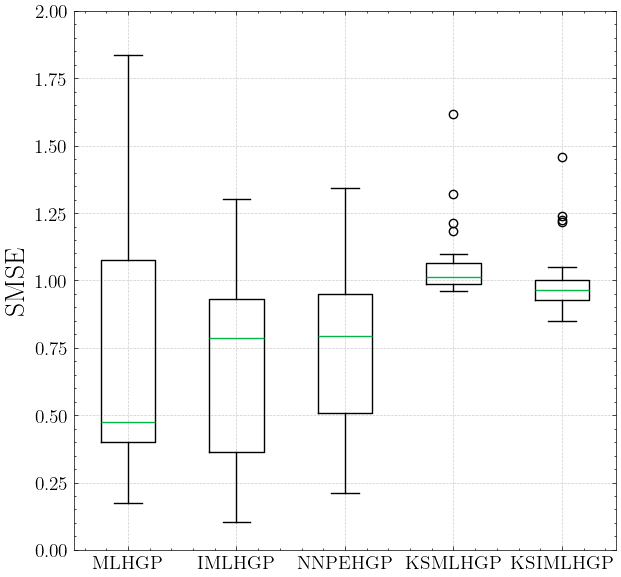

In [26]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["smse"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
ax.set_ylim(0,2)
ax.set_ylabel("SMSE")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/case3_2d/smse.pdf", dpi=300, format="pdf")
plt.show()

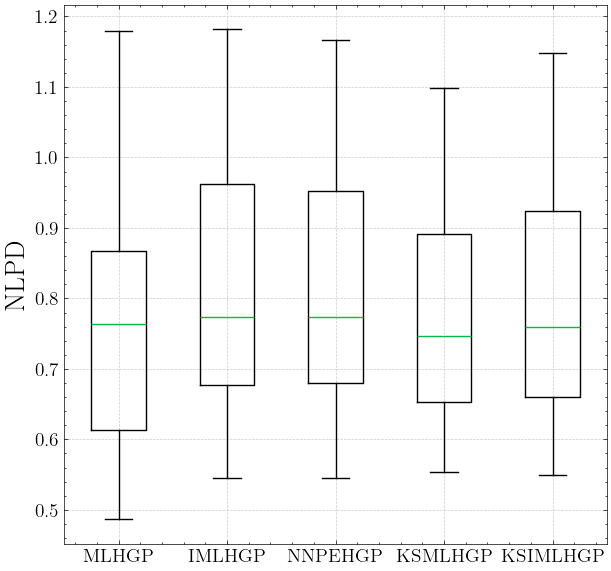

In [27]:
fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(model_scores["nlpd"].values())
ax.set_xticklabels(model_scores["wasserstein"].keys())
# ax.set_ylim(0,8)
ax.set_ylabel("NLPD")
plt.grid(True, color="0.8", linestyle='--')
plt.savefig("img/case3_2d/nlpd.pdf", dpi=300, format="pdf")
plt.show()